### 批量归一化
> * 损失出现在最后，后面的层训练较快，这是因为backward是从底层向前走的，越往数据走，乘的越多，数据越小，收敛越慢
> * 数据在最底部
>> * 底部的层训练较慢
>> * 底部层一变化，所有都得跟着变化
>> * 最后的那些层需要重新学习多次，导致收敛较慢
> * 固定小批量里面的均值和方差：$\mu_B = \frac{1}{|B|}\sum_{i\in B}x_i and \sigma_{B}^{2}=\frac{1}{|B|}\sum_{i\in B}(x_i-\mu_B)^2+\epsilon$, 防止方差为0，所以加上一个很小的值
> * 然后做额外的调整（可学习的参数为$\gamma , \beta$）：$x_{i+1}=\gamma \frac {x_i-\mu_B}{\sigma_B}+\beta$，$\beta$为新的均值，$\gamma^2$为新的方差
> * 作用在
>> * 全连接层和卷积层输出上，激活函数前
>> * 全连接层和卷积层输入上
> * 对全连接层，作用在特征维（所谓特征维即行数）
> * 对于卷积层，作用在通道维

### 批量归一化在做什么
> * 最初论文是想用它来减少内部协变量转移
> * 后续有论文指出它可能就是通过在每个小批量里加入噪音来控制模型复杂度,这里的噪音指的是上式中的$\gamma$和$\beta$，因为这两个值是取自当前随机小批量得来的， 并不是根据全局得来的
> * 因此没必要跟丢弃法（dropout）混合使用

### 总结
> * 批量归一化固定小批量中的均值和方差，然后学习出适合的偏移和缩放
> * 可以加速收敛速度，但一般不会改变模型精度

In [2]:
import torch
from torch import nn
from d2l import limutorch as d2l

def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    """moving_mean,moving_var相当于全局均值和全局方差"""
    """通过is_grad_enabled来判断当前是训练模式还是预测模式"""
    if not torch.is_grad_enabled():
        """如果是在预测模式下，相当于均值是1，方差为1，即r=1，b=0"""
        X_hat = (X - moving_mean) / torch.sqrt((moving_var + eps))
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            """使用全连接层时球均值和方差"""
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        X_hat = (X - mean) / torch.sqrt(var + eps)
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum *moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta
    return Y, moving_mean.data, moving_var.data

In [2]:
"""创建一个BatchNorm层"""
class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        Y, self.moving_mean, self.moving_var = batch_norm(X, self.gamma, self.beta,
                                                          self.moving_mean, self.moving_var,
                                                          eps=1e-5, momentum=0.9)
        return Y

In [3]:
"""应用BatchNorm于LeNet模型"""
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, 4), nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, 4), nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(), nn.Linear(16*4*4, 120), BatchNorm(120, 2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, 2), nn.Sigmoid(),
    nn.Linear(84, 10)
)

loss 0.239, train acc 0.911, test acc 0.838
29831.8 examples/sec on cuda:0


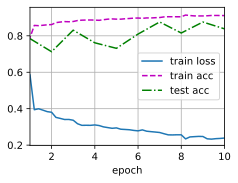

In [8]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [7]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([2.2630, 2.0857, 1.6323, 2.6489, 1.2028, 2.8902], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>),
 tensor([ 1.7173, -2.2834, -0.9054, -0.7806, -0.3038,  1.8977], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>))

In [6]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

loss 0.247, train acc 0.908, test acc 0.891
24889.7 examples/sec on cuda:0


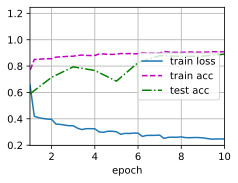

In [7]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())